# Control Theory

This notebook explore the dynamics and control of the cruise control system of a vehicle.

## Cruise Control System

The Cruise Control is a system that automatically controls the speed of a motor vehicle.

## Dynamics

While this does not intend to be a comprehensive vehicle dynamics model, we can use a simplified model to simulate the behavior of a vehicle. The vehicle produces a force that propels it forward.
This force, $F$, represents the throttle force and is limited by the engine power.

According to Newton's second law:

$$P = F \ v$$

where:
- $P \ $ is the power [watts]
- $F \ $ is the force [N]
- $v \ $ is the velocity  [m/s]

With this, we can estimate the $F_{max}$ for a vehicle will be its engine power divided by its maximum speed.

$$F = \frac{P}{v}$$

> Those values can be found in the vehicle's specifications.


This law also states that the acceleration of an object is directly proportional to the net force acting on it and inversely proportional to its mass. The law is given by the equation:

$$F = m \ a$$

For our vehicle model, the net force is the sum of the throttle force and the disturbance forces:

$$F_{net} = F - F_{d}$$

Then, the acceleration is given by:

$$a = \frac{F_{net}}{m}$$

### Disturbance Forces

We will take into account three major forces that act against the vehicle's motion. The sum of these forces will the disturbance force, $F_{d}$.

$$F_{d} = F_{g} + F_{r} + F_{a}$$

#### Gravity

The force of gravity is given by:

$$F_{g} = m \ g \ sin(\theta)$$

where:
- $m$ is the mass of the vehicle
- $g$ is the acceleration due to gravity
- $\theta$ is the elevation angle of the road

#### Rolling Friction

Rolling friction is the force that opposes the motion of the vehicle. It is given by: 

$$F_{r} = \mu \ N$$

where:
- $\mu$ is the coefficient of rolling friction
- $N$ is the normal force

#### Aerodynamic Drag Force

Drag depends on the properties of the fluid and on the size, shape, and speed of the object. One way to express this is by means of the drag equation:

$$F_{a} =  \frac{1}{2} \ c_{d} \ A  \ \rho \ v^2$$

where:
- $F_{d}$ is the drag force
- $\rho$ is the density of the fluid
- $v$ is the speed of the object relative to the fluid
- $A$ is the area of the object facing the fluid
- $c_{d}$ is the drag coefficient - a dimensionless number

> As we will evaluate aerodynamics, the '_fluid_' is the air.
 
At $101.325\ kPa$ (abs) and $15 °C$ ($59 °F$), air has a density of approximately $1.225 kg/m^3$ according to the [International Standard Atmosphere](https://en.wikipedia.org/wiki/International_Standard_Atmosphere) (ISA).

##### Typical Drag Coefficients values

| Object             | Drag Coefficient ($c_{d}$) |
|--------------------|----------------------------|
| Airfoil            | 0.05                       |
| Toyota Camry       | 0.28                       |
| Ford Focus         | 0.32                       |
| Honda Civic        | 0.36                       |
| Ferrari Testarossa | 0.37                       |
| Dodge Ram pickup   | 0.43                       |
| Bicycle            | 0.9                        |

Source: [College Physics, OpenStax](https://openstax.org/books/college-physics/pages/5-2-drag-forces)

In [ ]:
# Importing Required Libraries
from pydantic import BaseModel

# Constants
air_density = 1.225  # kg/m^3

### Vehicle Model

We can model a simplified vehicle dynamics using a python class.

In [ ]:
class Vehicle(BaseModel):
    """
    Vehicle Dynamics Model
    
    Attributes:
        position: current position of the vehicle (m)
        speed: current speed of the vehicle (m/s)
        mass: mass of the vehicle (Kg)
        max_throttle: maximum throttle force (N)
        drag_coefficient: drag coefficient (dimensionless)
        frontal_area: frontal area of the vehicle (m^2)
    """
    position: float = 0  # m
    speed: float = 0  # m/s
    mass: float  # Kg
    max_throttle: float  # N
    drag_coefficient: float  # dimensionless
    frontal_area: float  # m^2

#### Toyota Camry Example

![Toyota Camry](./assets/camry.png)

Toyota Camry XSE 2025 (4T1DAACK2SU017407)

According to the [Toyota](https://www.toyota.com/camry/2025) specifications, this unit drag coefficient ($c_{d}$) is approximately $0.37$ and the frontal area ($A$) is $1.94 m^2$. It weighs $3538 \ lbs$ ($1604 \ kg$) and has a maximum horsepower of $184hp$  ($137209 \ W$), and maximum top speed of $130mph$  ($209.2km/h$ or $58.33 m/s$).

We can estimate the maximum throttle force using the formula:



then

$$F_{throttle} = \frac{P}{v}$$
$$F_{throttle} = \frac{137209 \ watts}{58.33 \ m/s}$$
$$F_{throttle} = 2352 \ N$$



In [ ]:
camry = Vehicle(mass=1604, max_throttle=2352, drag_coefficient=0.37, frontal_area=1.94)
print(f"Toyota Camry XSE 2025({camry})")

In [1]:
from pydantic import BaseModel


class Vehicle(BaseModel):
    """
    Vehicle Dynamics Model
    """

    position: float = 0  # m
    speed: float = 0  # m/s
    mass: float = 1500  # Kg
    max_throttle: float = 4000  # N
    drag_coefficient: float = 0.3
    frontal_area: float = 2.2  # m^2
    air_density: float = 1.225  # kg/m^3

    def update(self, throttle: float, dt: float):
        """
        Simulate vehicle dynamics updating its position and speed.
        
        Args:
            throttle: amount of throttle to apply
            dt: time step
    
        Notes:
            - Drag force is calculated using the drag equation
            - Force = mass * acceleration
            - Acceleration is calculated using Newton's second law
        """
        # drag force = 1/2 * Cd * A * rho * v^2
        drag_force = 0.5 * self.drag_coefficient * self.frontal_area * self.air_density * self.speed ** 2
        # force = mass * acceleration
        acceleration = (min(self.max_throttle, throttle) - drag_force) / self.mass
        self.speed += acceleration * dt
        self.position += self.speed * dt

In [2]:
class PIDController(BaseModel):
    kp: float
    ki: float
    kd: float
    setpoint: float
    integral: float = 0
    previous_error: float = 0

    def update(self, measured_value: float, dt: float) -> float:
        """
        Update PID controller output
        
        Args:
            measured_value: current measured value
            dt: time step
        
        Returns:
            control signal
        """
        error = self.setpoint - measured_value
        self.integral += error * dt
        derivative = (error - self.previous_error) / dt
        output = self.kp * error + self.ki * self.integral + self.kd * derivative
        self.previous_error = error
        return output

In [3]:
# Simulation parameters
total_time = 3_600  # 1 hour
dt = 0.1  # time step
time = 0
set_speed = 28  # desired speed in m/s (100 km/h)

In [17]:
# Initialize Controller and Vehicle
pid = PIDController(kp=0.5, ki=0.1, kd=0.05, setpoint=set_speed)
vehicle = Vehicle(speed=0)

# Lists for storing simulation data
time_list = []
speed_list = []
position_list = []
acceleration_list = []

In [18]:
import numpy as np

# Run Simulation
for t in np.arange(0, total_time, dt):
    throttle = pid.update(vehicle.speed, dt)
    vehicle.update(throttle, dt)

    time_list.append(t)
    speed_list.append(vehicle.speed)
    acceleration_list.append(vehicle.speed / dt)
    position_list.append(vehicle.position)

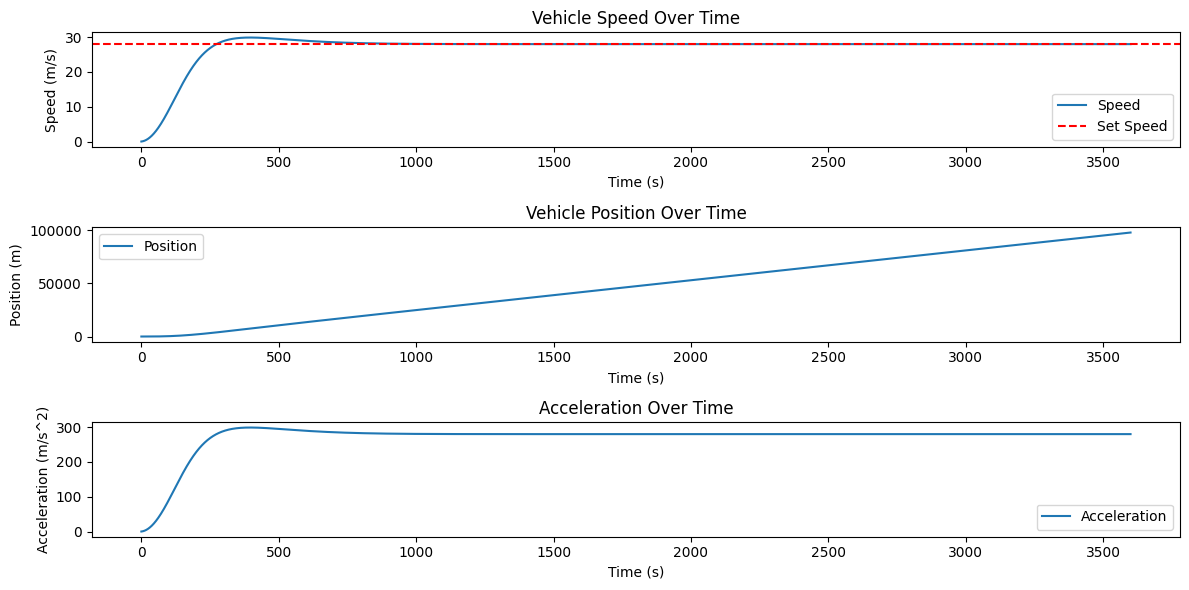

In [19]:
from matplotlib import pyplot as plt

# Plot Results
plt.figure(figsize=(12, 6))
plt.subplot(3, 1, 1)
plt.plot(time_list, speed_list, label='Speed')
plt.axhline(set_speed, color='r', linestyle='--', label='Set Speed')
plt.xlabel('Time (s)')
plt.ylabel('Speed (m/s)')
plt.title('Vehicle Speed Over Time')
plt.legend()

plt.subplot(3, 1, 2)
plt.plot(time_list, position_list, label='Position')
plt.xlabel('Time (s)')
plt.ylabel('Position (m)')
plt.title('Vehicle Position Over Time')
plt.legend()

plt.subplot(3, 1, 3)
plt.plot(time_list, acceleration_list, label='Acceleration')
plt.xlabel('Time (s)')
plt.ylabel('Acceleration (m/s^2)')
plt.title('Acceleration Over Time')
plt.legend()

plt.tight_layout()
plt.show()

In [12]:
print(np.clip(100 * 0.05, 0, 1))

1.0
